## HW5:

В домашньому завданні до даного модулю ви потренуєтесь робити тестове завдання для влаштування на роботу. 
За даними акселерометра з мобільного телефону потрібно класифікувати, якою діяльністю займається людина: йде, стоїть, біжить чи йде по сходах. 
Знайти датасет ви можете за посиланням....

Використайте алгоритми SVM та випадковий ліс з бібліотеки scikit-learn. Як характеристики можете брати показники з акселерометра, проте щоб покращити результати роботи алгоритмів, спочатку можна підготувати наш датасет і розрахувати часові ознаки (time domain features). Більше ці характеристики описані в даній статті.

Порівняйте результати роботи обох алгоритмів на різних фічах та різні моделі між собою.

In [315]:
import math as m
from pathlib import Path
import pickle
from typing import Union

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error
%matplotlib inline

## Data preparation:

In [316]:
def read_from_csvfile(file: Path) -> pd.DataFrame:
    """Read content from csv-file and return dataframe from content."""
    df = pd.read_csv(file)
    
    return df

In [317]:
df = pd.DataFrame()
classification_human_activity = {}

- https://www.geeksforgeeks.org/different-ways-to-create-pandas-dataframe/
- https://pandas.pydata.org/docs/reference/api/pandas.concat.html
- https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.std.html
- https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.skew.html
- https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.kurt.html
- https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.var.html
- https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.idxmax.html
- https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.idxmin.html
- https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.entropy.html
- https://stackoverflow.com/questions/53177327/how-to-compute-shannon-entropy-of-information-from-a-pandas-dataframe
- https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html
- https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_absolute_error.html

In [318]:
def get_statistical_features(y: str, df: pd.DataFrame) -> pd.DataFrame:
    # y - type real data; df - sample data. 
    if y not in classification_human_activity:
        classification_human_activity[y] = len(classification_human_activity)

    data = {'activity': [classification_human_activity[y]]}

    [data.update({
                  f'max_{col[-1]}':[max(df[col])],
                  f'min_{col[-1]}':[min(df[col])],
                  f'mean_{col[-1]}':[df[col].mean(axis=0)],
                  f'med_{col[-1]}':[df[col].median(axis=0)],  # median
                  f'std_{col[-1]}':[df[col].std(axis=0)],  # Standard deviation
                  f'skew_{col[-1]}':[df[col].skew(axis=0)],  # skewness
                  f'kurt_{col[-1]}':[df[col].kurt(axis=0)],  # kurtosis
                  f'var_{col[-1]}':[df[col].var(axis=0)],  # variance
                  f'idxmax_{col[-1]}':[df[col].idxmax(axis=0)],  # index of first occurrence of maximum over requested axis
                  f'idxmin_{col[-1]}':[df[col].idxmin(axis=0)],  # index of first occurrence of minimum over requested axis
                  }) 
        for col in df.columns]

    [data.update({
                  f'rmse_{col[-1]}':[mean_squared_error(df[col], [data[f'mean_{col[-1]}'] for __ in range(df.shape[0])], squared=False)],  # variance# Root Mean Square Error
                  f'mae_{col[-1]}':[mean_absolute_error(df[col], [data[f'mean_{col[-1]}'] for __ in range(df.shape[0])])],  # mean absolute error
                  }) 
        for col in df.columns]
    
    df_f = pd.DataFrame(data)
    
    return df_f

In [319]:
def get_data_to_dafaframe(path: Union[str, Path], df: pd.DataFrame) -> pd.DataFrame:
    path = Path(path)
    if not path.is_dir() or not path.exists():
        return None
    
    for file_system_object in path.iterdir():
        if file_system_object.is_dir():
            df = get_data_to_dafaframe(file_system_object, df)
            
        elif file_system_object.suffix.lower() in ('.csv',):
            df_add = read_from_csvfile(file_system_object)
            df = pd.concat([df, get_statistical_features(file_system_object.stem.split('-')[0], df_add)], ignore_index=True)

    return df

In [320]:
def save_prepared_data(df: pd.DataFrame, file_name: str='data1.bin') -> None:
    with open(file_name, 'wb') as fh:
        pickle.dump(df, fh)


In [321]:
def load_prepared_data(file_name: str='data1.bin') -> pd.DataFrame:
    with open(file_name, 'rb') as fh:
        df = pickle.load(fh)

    return df

Якщо немає підготовлених даних (data0.bin & data1.bin) - обробляємо знову з сирих

In [322]:
if Path('data0.bin').is_file() and Path('data1.bin').is_file():
    df = load_prepared_data()
    classification_human_activity = load_prepared_data('data0.bin')

else:
    df = get_data_to_dafaframe('data', df)
    save_prepared_data(df)
    save_prepared_data(classification_human_activity, 'data0.bin')

In [323]:
df.tail(6)

,activity,max_X,min_X,mean_X,med_X,std_X,skew_X,kurt_X,var_X,idxmax_X,...,kurt_Z,var_Z,idxmax_Z,idxmin_Z,rmse_X,mae_X,rmse_Y,mae_Y,rmse_Z,mae_Z
6456,3,1.024718,-10.036493,-3.997519,-3.380613,3.011451,-0.338673,-0.557672,9.068838,5,...,0.374707,6.062126,26,21,2.960835,2.408620,4.719099,3.860922,2.420755,1.881598
6457,3,8.398860,-6.224924,0.826638,1.244985,2.653484,-0.012359,2.275576,7.040978,8,...,9.031841,30.027026,7,11,2.608884,1.942251,3.153400,2.494843,5.387590,3.226745
6458,3,12.196063,-6.354211,2.587334,2.506730,3.311198,-0.104480,3.238238,10.964034,16,...,4.507524,10.078007,28,16,3.255544,2.209689,5.150007,4.039338,3.121230,1.975557
6459,3,8.073248,-4.582502,2.830745,3.447650,3.302172,-0.492919,-0.453013,10.904337,11,...,3.758635,20.366468,27,29,3.246669,2.650009,4.630977,3.314692,4.437069,2.838800
6460,3,9.035717,-6.904877,-0.025219,-0.399831,3.414785,0.284005,0.775833,11.660759,1,...,2.128289,19.916885,1,29,3.357390,2.592356,5.177956,3.986420,4.387823,2.956030
6461,3,8.398860,-6.224924,0.964544,1.376666,2.958615,-0.059084,0.721621,8.753403,20,...,4.863290,39.297190,19,23,2.908887,2.250614,4.252132,3.073357,6.163382,4.058800


Розшифровка позначень типів діяльності

In [324]:
classification_human_activity

{'walking': 0, 'running': 1, 'idle': 2, 'stairs': 3}

In [325]:
if not classification_human_activity.get(0):
    classification_human_activity = {val:key for key, val in classification_human_activity.items()}

classification_human_activity

{0: 'walking', 1: 'running', 2: 'idle', 3: 'stairs'}

In [326]:
X = df.iloc[:, 1:]
y = df.iloc[:, 0]

- https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

(рандомне перемішування даних shuffle=True може суттєво впливати на результати співставлення різних алгоритмів, усереднено - орієнтовно достатня точність)

In [327]:
from sklearn.model_selection import train_test_split

# Робимо вибірки - розділяємо всі дані на групи для тренування, валідаційну та тестову
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=True)  # random_state=42
X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test, test_size=0.5, shuffle=True)
X_train.shape, X_valid.shape, X_test.shape, y_train.shape, y_valid.shape, y_test.shape

((4329, 36), (1066, 36), (1067, 36), (4329,), (1066,), (1067,))

## SVC Model training

In [328]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

Натренуємо модельки (ймовірність - probability)

In [329]:
C = [10**q for q in range(-3, 4)]  # 7
gamma = [10**g for g in range(-2, 1)]  # 3+
gamma.append('auto')
degree = [d for d in range(2,7)]  # 6
models_svc_linear = {f'linear>C={coef_C}':SVC(kernel='linear', C=coef_C, probability=True).fit(X_train, y_train) for coef_C in C}
models_svc_rbf = {f'rbf>C={coef_C};g={coef_g}': SVC(kernel='rbf', C=coef_C, gamma=coef_g, probability=True).fit(X_train, y_train) for coef_C in C for coef_g in gamma}
models_svc_poly = {f'poly>C={coef_C};d={deg}': SVC(kernel='poly', degree=deg, C=coef_C, probability=True).fit(X_train, y_train) for coef_C in C for deg in degree}

- https://towardsdatascience.com/predict-vs-predict-proba-scikit-learn-bdc45daa5972

In [330]:
# отримаємо значення моделей за валідаційними/тестовими вибірками і перевіримо узагальнену точність [accuracy_score, f1_score, ]
def run_model(model: SVC, new_data: pd.DataFrame, real_result: pd.Series) -> list:
    y_valid_pred = model.predict_proba(new_data)  # [:, 2]  # probability for classification_human_activity[2]
    from_model_by_max = pd.DataFrame(y_valid_pred).idxmax(1).values
    m1 = accuracy_score(real_result, from_model_by_max)
    m2 = f1_score(real_result, from_model_by_max, average='weighted')  # None = for each class
    # roc_auc_score(real_result, y_valid_pred)  #! multi_class must be in ('ovo', 'ovr')
    
    return [m1, m2]

In [331]:
# обрахуємо результати перевірки за моделями (валідації/тесту)
def get_model_results(
                      X_valid: pd.DataFrame, 
                      y_valid: pd.Series, 
                      models_svc_linear: dict=None, 
                      models_svc_rbf: dict=None, 
                      models_svc_poly: dict=None
                      ) -> pd.DataFrame:
    valid_linear = {mark:run_model(model, X_valid, y_valid) for mark, model in models_svc_linear.items()} if models_svc_linear else {}
    valid_rbf = {mark:run_model(model, X_valid, y_valid) for mark, model in models_svc_rbf.items()} if models_svc_rbf else {}
    valid_poly = {mark:run_model(model, X_valid, y_valid) for mark, model in models_svc_poly.items()} if models_svc_poly else {}

    valid_results = {}
    valid_results.update(valid_linear)
    valid_results.update(valid_rbf)
    valid_results.update(valid_poly)
    valid_results = pd.DataFrame(valid_results).T

    valid_results.columns = ['accuracy_score', 'f1_score', ]

    return valid_results


In [332]:
# Порахуємо результати узагальнених точностей за моделями для різних вибірок
train_results = get_model_results(X_train, y_train, models_svc_linear, models_svc_rbf, models_svc_poly)
valid_results = get_model_results(X_valid, y_valid, models_svc_linear, models_svc_rbf, models_svc_poly)
test_results = get_model_results(X_test, y_test, models_svc_linear, models_svc_rbf, models_svc_poly)

In [333]:
# Порівняємо результати візуально
def show_compare_accuracy_scatter(x: pd.Series, data: pd.DataFrame) -> None:
    plt.figure(figsize=(16,7))
    [ax := sns.scatterplot(x=x, y=ac, data=data, label=ac) for ac in valid_results.columns]

    plt.xticks(rotation=85)
    plt.ylabel('accuracy value', fontsize='small', color='midnightblue')
    plt.grid()
    ax.legend()
    plt.show()

- https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.sort_values.html
- https://www.geeksforgeeks.org/how-to-sort-pandas-dataframe/

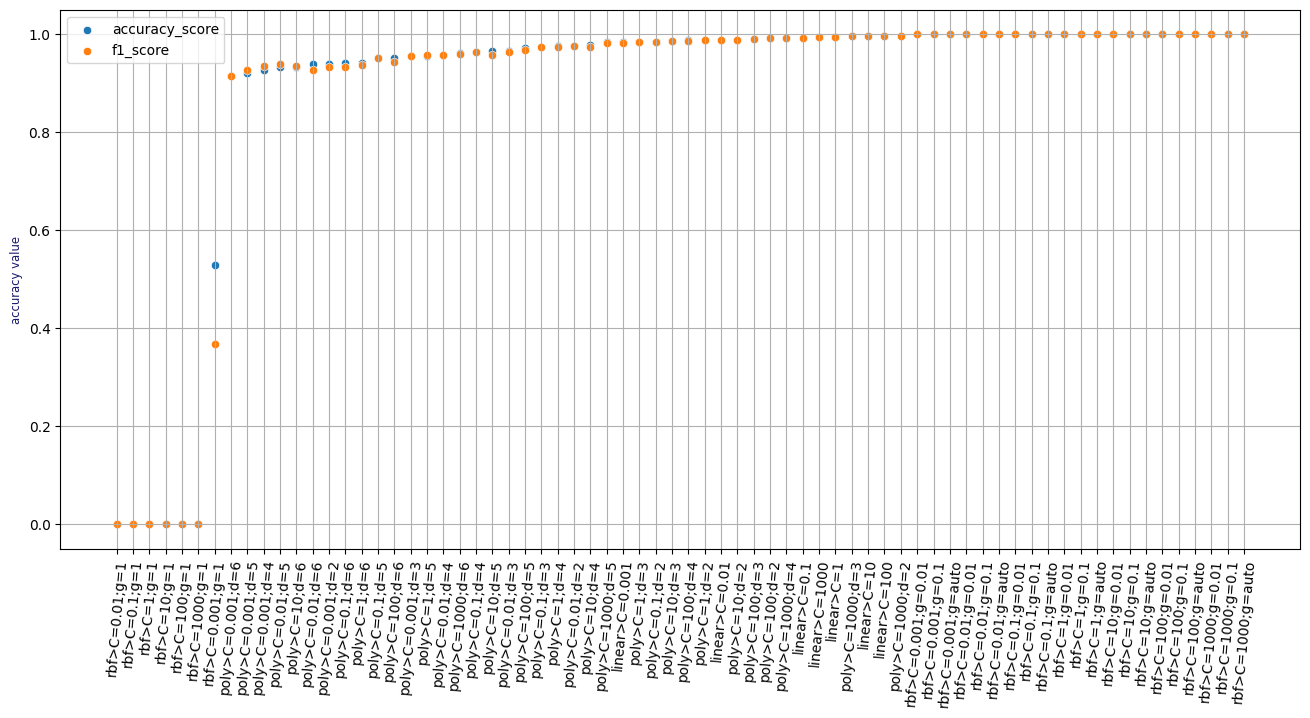

In [334]:
# Порівняння точності за тренувальними вибірками для різних моделей
train_results = train_results.sort_values(by=['accuracy_score', 'f1_score'])
show_compare_accuracy_scatter(x=train_results.index, data=train_results)

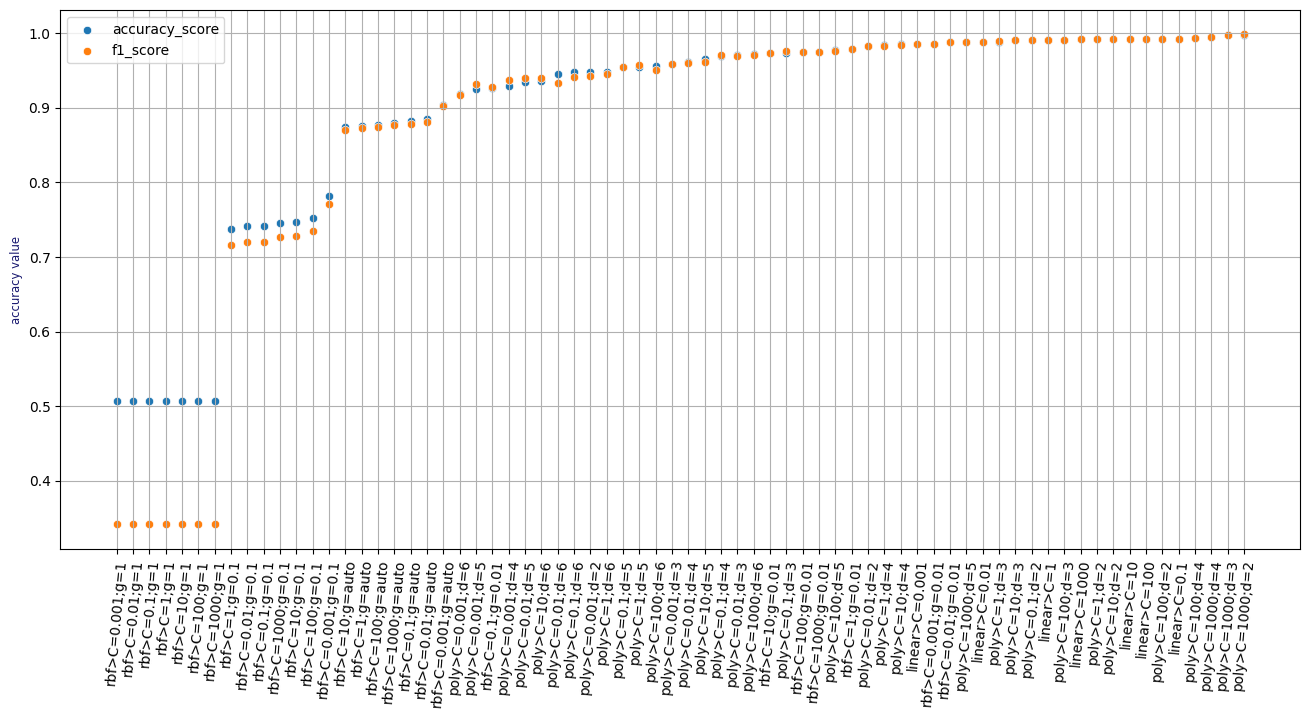

In [335]:
# Порівняння точності за валідаційними вибірками для різних моделей
valid_results = valid_results.sort_values(by=['accuracy_score', 'f1_score'])
show_compare_accuracy_scatter(x=valid_results.index, data=valid_results)

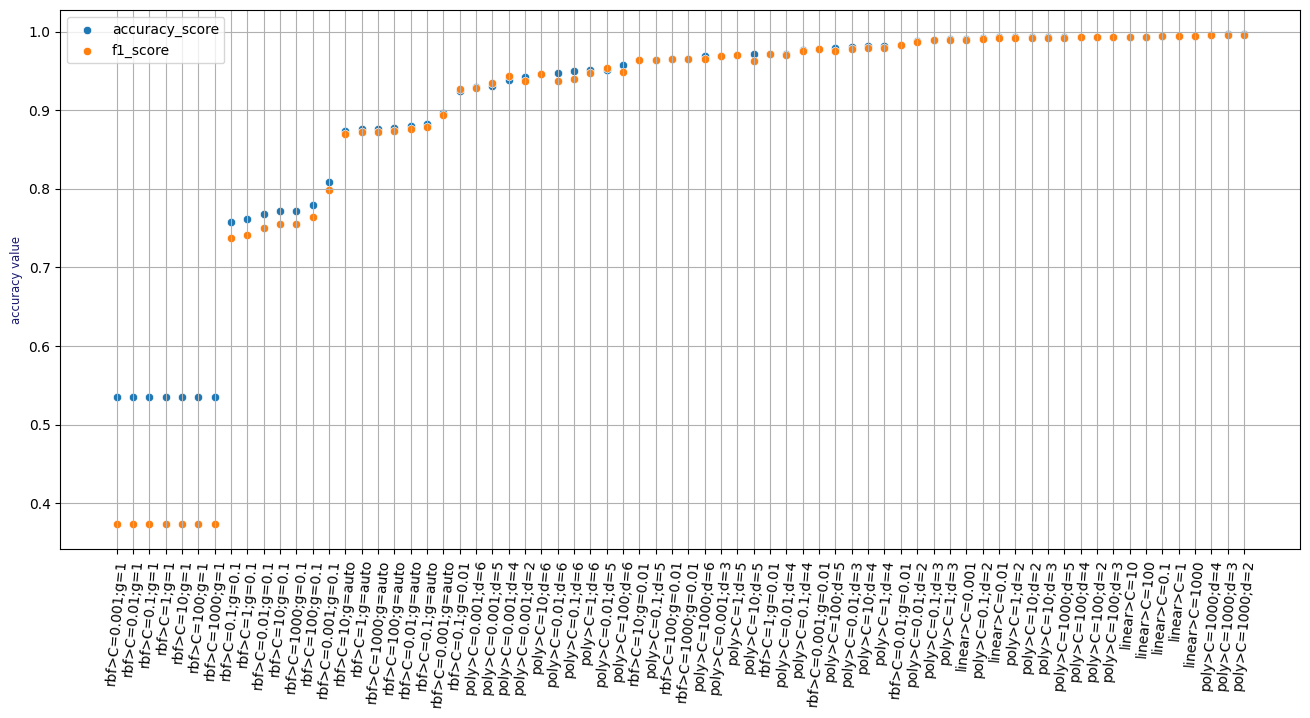

In [336]:
# Порівняння точності за тестовими вибірками для різних моделей
test_results = test_results.sort_values(by=['accuracy_score', 'f1_score'])
show_compare_accuracy_scatter(x=test_results.index, data=test_results)

In [337]:
train_results[train_results['accuracy_score'] >= 0.995]

,accuracy_score,f1_score
linear>C=1,0.995149,0.995098
poly>C=1000;d=3,0.996304,0.996252
linear>C=10,0.996766,0.996697
linear>C=100,0.997459,0.997422
poly>C=1000;d=2,0.997459,0.997433
rbf>C=0.001;g=0.01,1.000000,1.000000
rbf>C=0.001;g=0.1,1.000000,1.000000
rbf>C=0.001;g=auto,1.000000,1.000000
rbf>C=0.01;g=0.01,1.000000,1.000000
rbf>C=0.01;g=0.1,1.000000,1.000000


In [338]:
# Подивимося на 'найкращі' моделі за результатом роботи моделей для різних вибірок
valid_results.iloc[-4:], test_results.iloc[-4:]

(                 accuracy_score  f1_score
 poly>C=100;d=4         0.993433  0.993227
 poly>C=1000;d=4        0.994371  0.994551
 poly>C=1000;d=3        0.997186  0.997209
 poly>C=1000;d=2        0.998124  0.998154,
                  accuracy_score  f1_score
 linear>C=1000          0.994377  0.994162
 poly>C=1000;d=4        0.995314  0.995079
 poly>C=1000;d=3        0.996251  0.996108
 poly>C=1000;d=2        0.996251  0.996183)

In [339]:
"""
Варіант з перемішуванням 1:
(                 accuracy_score  f1_score
 linear>C=0.1           0.993433  0.993181
 linear>C=1             0.993433  0.993181
 poly>C=1000;d=2        0.995310  0.995124
 poly>C=1000;d=3        0.997186  0.997121,
                  accuracy_score  f1_score
 linear>C=1             0.996251  0.996113
 poly>C=1000;d=2        0.996251  0.996185
 poly>C=1000;d=3        0.996251  0.996185
 linear>C=100           0.997188  0.997164)

 Варіант з перемішуванням 2:
 (                 accuracy_score  f1_score
 linear>C=1000           0.99531  0.995094
 linear>C=1              0.99531  0.995242
 linear>C=0.1            0.99531  0.995373
 poly>C=1000;d=2         0.99531  0.995373,
                  accuracy_score  f1_score
 linear>C=100           0.993440  0.993282
 linear>C=10            0.994377  0.994377
 poly>C=1000;d=3        0.997188  0.997167
 poly>C=1000;d=2        1.000000  1.000000)

Варіант з перемішуванням 3:
(               accuracy_score  f1_score
 linear>C=100         0.993433  0.993381
 linear>C=1000        0.993433  0.993484
 linear>C=1           0.994371  0.994371
 linear>C=10          0.995310  0.995272,
                  accuracy_score  f1_score
 linear>C=1000          0.990628  0.990262
 linear>C=1             0.990628  0.990628
 poly>C=1000;d=3        0.992502  0.992194
 poly>C=1000;d=2        0.996251  0.996203)

 Варіант з перемішуванням 5:
 (                 accuracy_score  f1_score
 linear>C=0.1           0.993433  0.993037
 linear>C=0.01          0.993433  0.993162
 poly>C=1000;d=2        0.994371  0.994086
 linear>C=1             0.995310  0.995198,
                  accuracy_score  f1_score
 poly>C=100;d=3         0.992502  0.992507
 poly>C=100;d=2         0.994377  0.994285
 poly>C=1000;d=3        0.995314  0.995197
 poly>C=1000;d=2        0.997188  0.997118)
"""


'\nВаріант з перемішуванням 1:\n(                 accuracy_score  f1_score\n linear>C=0.1           0.993433  0.993181\n linear>C=1             0.993433  0.993181\n poly>C=1000;d=2        0.995310  0.995124\n poly>C=1000;d=3        0.997186  0.997121,\n                  accuracy_score  f1_score\n linear>C=1             0.996251  0.996113\n poly>C=1000;d=2        0.996251  0.996185\n poly>C=1000;d=3        0.996251  0.996185\n linear>C=100           0.997188  0.997164)\n\n Варіант з перемішуванням 2:\n (                 accuracy_score  f1_score\n linear>C=1000           0.99531  0.995094\n linear>C=1              0.99531  0.995242\n linear>C=0.1            0.99531  0.995373\n poly>C=1000;d=2         0.99531  0.995373,\n                  accuracy_score  f1_score\n linear>C=100           0.993440  0.993282\n linear>C=10            0.994377  0.994377\n poly>C=1000;d=3        0.997188  0.997167\n poly>C=1000;d=2        1.000000  1.000000)\n\nВаріант з перемішуванням 3:\n(               accu

In [340]:
# орієнтовно зважено можна сказати, що poly>C=1000;d=2, poly>C=1000;d=3, та linear> одні з найкащих
# Розглянемо linear>C=1
first_result = (train_results.loc['linear>C=1'], valid_results.loc['linear>C=1'], test_results.loc['linear>C=1'])
first_result

(accuracy_score    0.995149
 f1_score          0.995098
 Name: linear>C=1, dtype: float64,
 accuracy_score    0.990619
 f1_score          0.990912
 Name: linear>C=1, dtype: float64,
 accuracy_score    0.994377
 f1_score          0.994162
 Name: linear>C=1, dtype: float64)

In [341]:
best_model = models_svc_linear.get('linear>C=1')

In [342]:
X.columns

Index(['max_X', 'min_X', 'mean_X', 'med_X', 'std_X', 'skew_X', 'kurt_X',
       'var_X', 'idxmax_X', 'idxmin_X', 'max_Y', 'min_Y', 'mean_Y', 'med_Y',
       'std_Y', 'skew_Y', 'kurt_Y', 'var_Y', 'idxmax_Y', 'idxmin_Y', 'max_Z',
       'min_Z', 'mean_Z', 'med_Z', 'std_Z', 'skew_Z', 'kurt_Z', 'var_Z',
       'idxmax_Z', 'idxmin_Z', 'rmse_X', 'mae_X', 'rmse_Y', 'mae_Y', 'rmse_Z',
       'mae_Z'],
      dtype='object')

In [343]:
best_model.coef_


array([[-1.33076579e-02, -1.18135874e-02, -1.25944400e-02,
        -1.31203384e-02, -9.19627910e-04, -1.58785816e-04,
         2.06571544e-03, -8.74892060e-03,  3.08562198e-03,
         3.76267118e-03, -2.32882335e-02, -3.48652636e-02,
        -4.35678134e-02, -4.64481417e-02,  3.48284517e-04,
         3.07769496e-03,  6.09714936e-03, -2.60759624e-03,
         3.47894295e-03,  8.27917059e-04,  7.52131981e-03,
        -3.90176135e-03, -1.38963270e-02, -1.34055605e-02,
        -7.06330805e-04,  3.10381125e-03,  1.09659100e-02,
        -1.67085786e-03, -1.82122340e-03, -3.75760878e-03,
        -9.04170878e-04, -1.03339592e-03,  3.42430579e-04,
        -5.68135790e-04, -6.94458853e-04, -2.91442250e-03],
       [-3.09233356e-03, -1.22784687e-02, -5.03824609e-03,
        -4.62171455e-03,  3.29648398e-03, -2.04513787e-03,
        -9.63379030e-03,  1.23267397e-02, -3.05129893e-04,
         6.91320517e-04, -1.39791804e-02, -2.40485814e-02,
        -2.05922806e-02, -1.72443298e-02,  1.34737334e-

In [344]:
data = pd.DataFrame(best_model.coef_)
data.columns = X.columns
data = data.abs()
data = data.iloc[-1].sort_values()
biggest = data[data.values >= 0.5*data.max()].index
biggest

Index(['max_Y', 'med_Y', 'mean_Z', 'mean_Y', 'med_Z', 'min_Z', 'min_Y'], dtype='object')

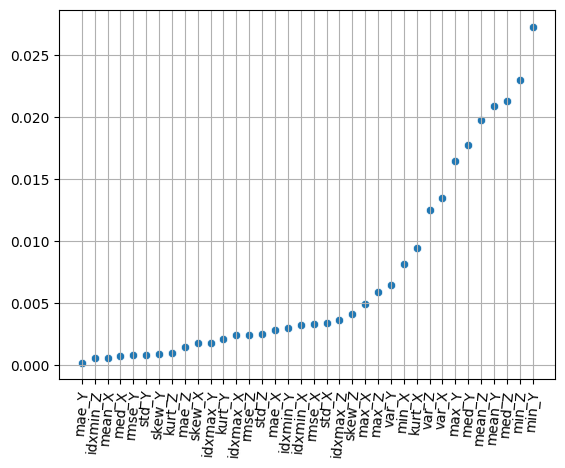

In [345]:
plt.figure()
sns.scatterplot(x=data.index, y=data.values, data=data)
plt.xticks(rotation=85)
plt.grid()
plt.show()

In [346]:
X = X.filter(items=[col for col in biggest])
X

,max_Y,med_Y,mean_Z,mean_Y,med_Z,min_Z,min_Y
0,-1.470040,-10.249578,-0.793758,-9.659965,-0.938527,-14.695610,-17.980455
1,-0.311246,-9.866505,0.218830,-10.444944,-1.781286,-16.223110,-22.443247
2,0.311246,-12.035652,-2.173296,-11.915463,-1.072602,-25.182213,-27.140670
3,8.834604,-11.935095,-2.455174,-10.401370,-0.926556,-33.949780,-28.773516
4,3.586514,-8.980650,-1.350170,-8.448340,-0.723048,-20.216639,-16.314090
...,...,...,...,...,...,...,...
6457,-2.715025,-9.035717,-4.078762,-8.694463,-3.584120,-26.230873,-17.501614
6458,3.016694,-8.477868,-1.258233,-9.039388,-1.067814,-11.789049,-21.049822
6459,2.973599,-7.153874,-0.104068,-7.161376,0.019154,-14.422671,-17.300500
6460,-1.489193,-9.631874,-0.760239,-9.817344,-0.955286,-10.491392,-22.720974


In [347]:
# Робимо вибірки - розділяємо лише важливіші дані на групи для тренування, валідаційну та тестову
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=True)  # random_state=42
X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test, test_size=0.5, shuffle=True)
X_train.shape, X_valid.shape, X_test.shape, y_train.shape, y_valid.shape, y_test.shape

((4329, 7), (1066, 7), (1067, 7), (4329,), (1066,), (1067,))

# повторимо створення та оцінку моделей для лише за 'найвагомішими' параметрами

In [348]:
# C = [10**q for q in range(-3, 4)]  # 7
# gamma = [10**g for g in range(-2, 1)]  # 3+
# gamma.append('auto')
# degree = [d for d in range(2,7)]  # 6
models_svc_linear = {f'linear>C={coef_C}':SVC(kernel='linear', C=coef_C, probability=True).fit(X_train, y_train) for coef_C in C}
models_svc_rbf = {f'rbf>C={coef_C};g={coef_g}': SVC(kernel='rbf', C=coef_C, gamma=coef_g, probability=True).fit(X_train, y_train) for coef_C in C for coef_g in gamma}
models_svc_poly = {f'poly>C={coef_C};d={deg}': SVC(kernel='poly', degree=deg, C=coef_C, probability=True).fit(X_train, y_train) for coef_C in C for deg in degree}

In [349]:
# Порахуємо результати узагальнених точностей за новими моделями для різних вибірок
train_results = get_model_results(X_train, y_train, models_svc_linear, models_svc_rbf, models_svc_poly)
valid_results = get_model_results(X_valid, y_valid, models_svc_linear, models_svc_rbf, models_svc_poly)
test_results = get_model_results(X_test, y_test, models_svc_linear, models_svc_rbf, models_svc_poly)

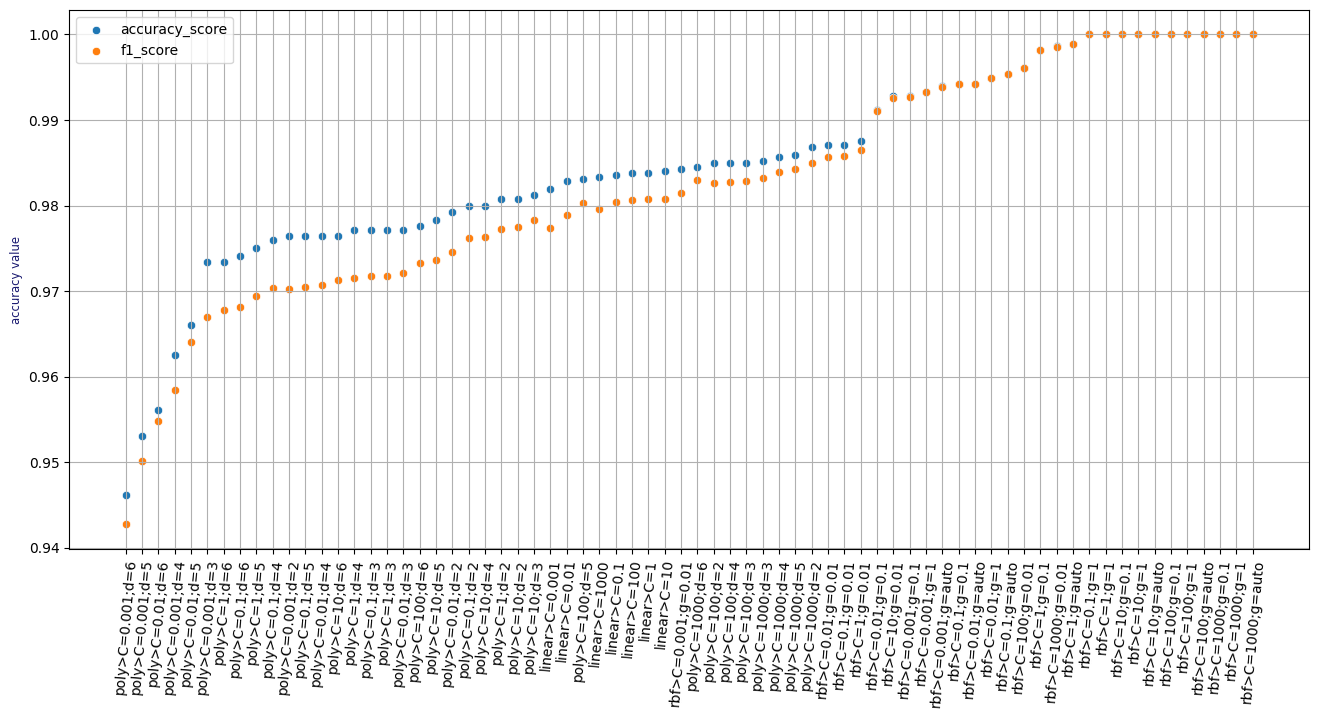

In [350]:
# Порівняння точності за тренувальними вибірками для різних моделей
train_results = train_results.sort_values(by=['accuracy_score', 'f1_score'])
show_compare_accuracy_scatter(x=train_results.index, data=train_results)

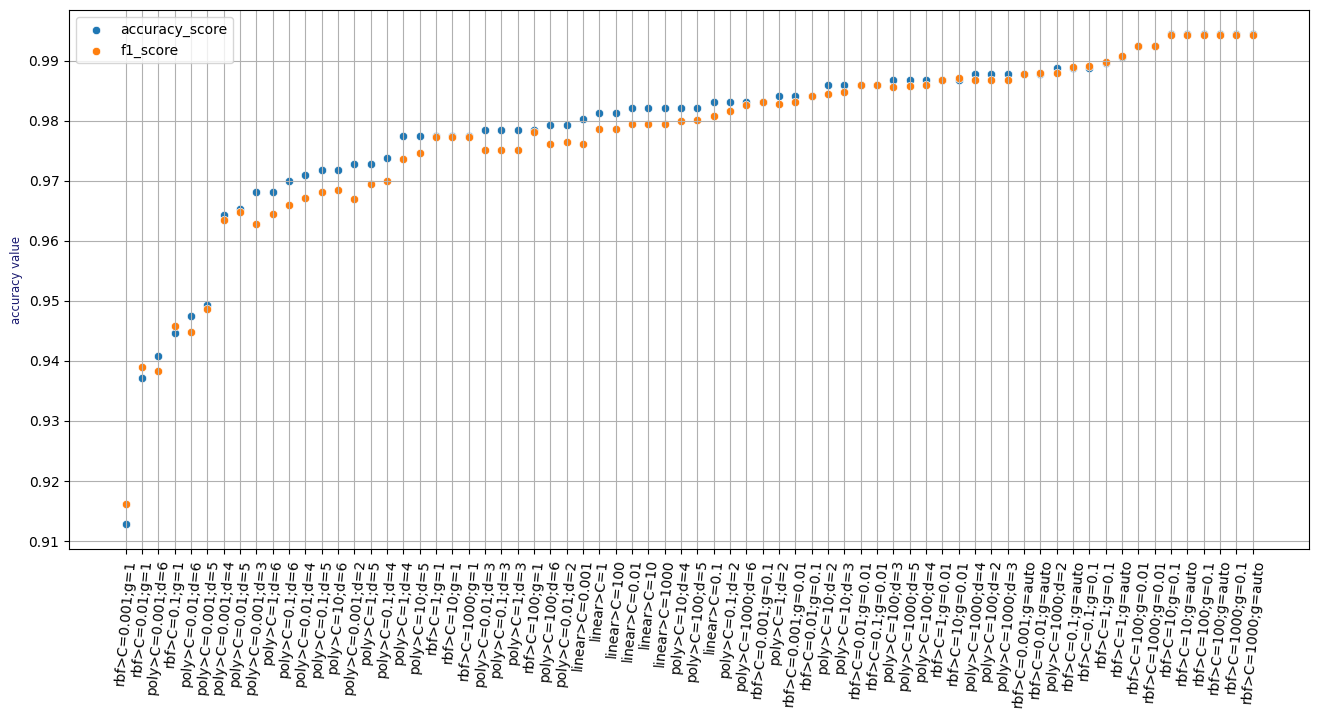

In [351]:
# Порівняння точності за валідаційними вибірками для різних моделей
valid_results = valid_results.sort_values(by=['accuracy_score', 'f1_score'])
show_compare_accuracy_scatter(x=valid_results.index, data=valid_results)

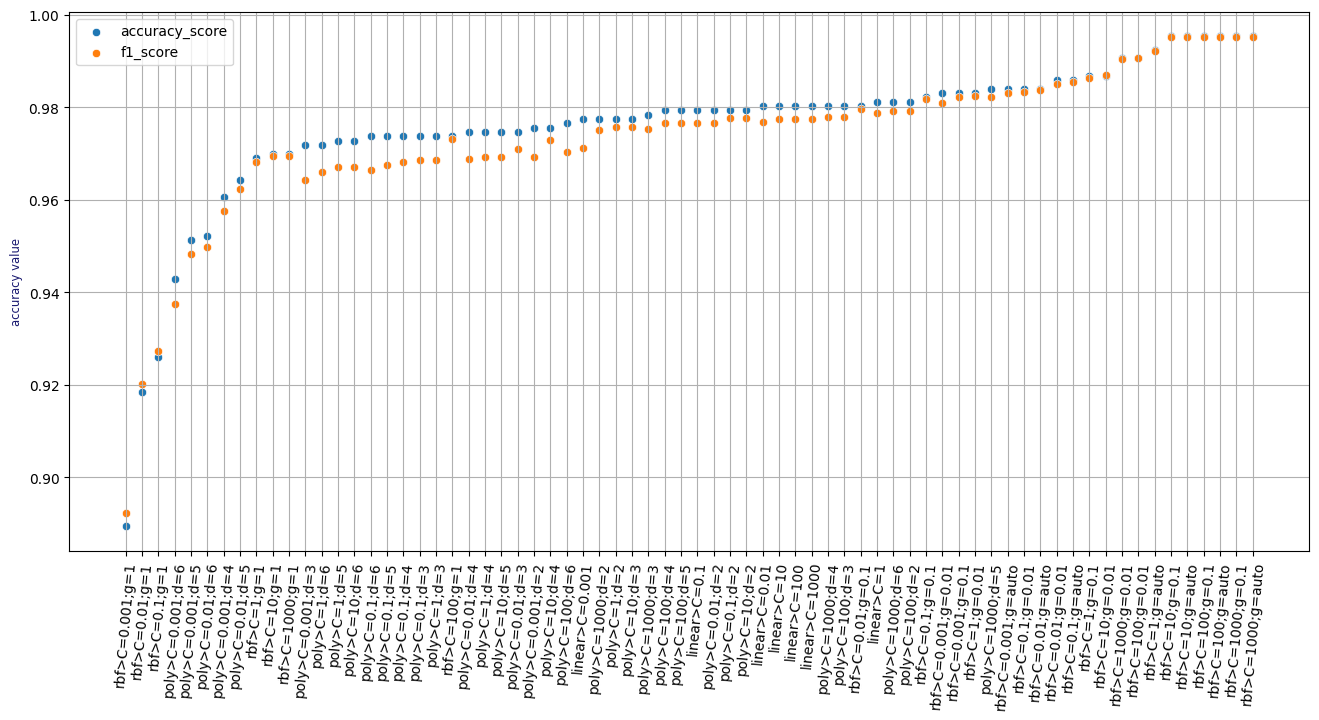

In [352]:
# Порівняння точності за тестовими вибірками для різних моделей
test_results = test_results.sort_values(by=['accuracy_score', 'f1_score'])
show_compare_accuracy_scatter(x=test_results.index, data=test_results)

In [353]:
train_results[train_results['accuracy_score'] >= 0.981]

,accuracy_score,f1_score
poly>C=10;d=3,0.981289,0.978369
linear>C=0.001,0.981982,0.977357
linear>C=0.01,0.982906,0.978872
poly>C=100;d=5,0.983137,0.980278
linear>C=1000,0.983368,0.979607
linear>C=0.1,0.983599,0.980424
linear>C=100,0.983830,0.980628
linear>C=1,0.983830,0.980771
linear>C=10,0.984061,0.980832
rbf>C=0.001;g=0.01,0.984292,0.981455


In [354]:
# Подивимося на 'найкращі' моделі за результатом роботи моделей для різних вибірок
valid_results.iloc[-6:], test_results.iloc[-6:]

(                   accuracy_score  f1_score
 rbf>C=10;g=0.1           0.994371  0.994332
 rbf>C=10;g=auto          0.994371  0.994332
 rbf>C=100;g=0.1          0.994371  0.994332
 rbf>C=100;g=auto         0.994371  0.994332
 rbf>C=1000;g=0.1         0.994371  0.994332
 rbf>C=1000;g=auto        0.994371  0.994332,
                    accuracy_score  f1_score
 rbf>C=10;g=0.1           0.995314   0.99527
 rbf>C=10;g=auto          0.995314   0.99527
 rbf>C=100;g=0.1          0.995314   0.99527
 rbf>C=100;g=auto         0.995314   0.99527
 rbf>C=1000;g=0.1         0.995314   0.99527
 rbf>C=1000;g=auto        0.995314   0.99527)

In [355]:
# Розглянемо поточну версію попередньо вибраної як найкращу linear>C=1
second_result = (train_results.loc['linear>C=1'], valid_results.loc['linear>C=1'], test_results.loc['linear>C=1'])
second_result

(accuracy_score    0.983830
 f1_score          0.980771
 Name: linear>C=1, dtype: float64,
 accuracy_score    0.981238
 f1_score          0.978611
 Name: linear>C=1, dtype: float64,
 accuracy_score    0.981256
 f1_score          0.978751
 Name: linear>C=1, dtype: float64)

In [358]:
# орієнтовний приріст швидкодії моделей при зменшенні з 36 фіч до 7 (= в разів)
(6 * 60 + 5) / (1 * 60 + 50)
(6 * 60 + 30) / (1 * 60 + 41)

3.8613861386138613

In [365]:
# зменшення точності лінійної моделі 'linear>C=1', орієнтовно
for fr, sr in zip(first_result, second_result):
    print(f'''accuracy_score decrease by {round((1 - sr['accuracy_score']/fr['accuracy_score'])*100, 2)} %\n''')
    print(f'''f1_score decrease by {round((1 - sr['f1_score']/fr['f1_score'])*100, 2)} %\n''')

accuracy_score decrease by 1.14 %

f1_score decrease by 1.44 %

accuracy_score decrease by 0.95 %

f1_score decrease by 1.24 %

accuracy_score decrease by 1.32 %

f1_score decrease by 1.55 %

